In [1]:
# Import libraries
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.autograd.functional import jacobian



from ipywidgets import IntProgress
from IPython.display import display
from matplotlib import pyplot as plt, rc
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
rc('animation', html='jshtml')
# !pip install jupyterthemes
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)


In [2]:
# define objective fucntion
f =lambda x: x[0] ** 2 + x[1] ** 2 + x[2] ** 2 

# define constraints
h1 = lambda x: ((x[0] ** 2) / 4) + ((x[1] ** 2) / 5) + ((x[2] ** 2) / 25) - 1
h2 = lambda x: x[0] + x[1] - x[2]

# initialize Variables
x = Variable(torch.tensor([1,1.,1.]), requires_grad=True)
eps= 1e-03

We have $n=3$ and $m=2$ here, so the DOF of systme is $n-m = 1$ \
meanwe have only one decision variable variable and two state variable \
let say: \
$x_1 $ here is the decision variable \
$ x_2$  and  $x_3$ are the state variables \


In [3]:
# Calculating Reduce Gradient using jacobian
def RJ(f,h1,h2,x):
  #compute Jacobian
  Jocobian = torch.zeros((3, 3))
  Jocobian[0] = jacobian(f, (x))
  Jocobian[1] = jacobian(h1, (x))
  Jocobian[2] = jacobian(h2, (x))

  # reduce Gradient variables
  dfdd = Jocobian[0,0]
  dfds = Jocobian[0,1:]
  dhds = Jocobian[1:,1:]
  dhdd = Jocobian[1:,0]

  #compute reduce Gradient 
  DfDd =  dfdd - torch.matmul(torch.matmul(dfds,torch.pinverse(dhds)),dhdd)
  return  DfDd, dfdd, dfds, dhds, dhdd

In [4]:
def LM(x):
  ''' Levenberg -Marquardt'''
  Lambda = 1. 
  norm = torch.norm(torch.tensor([h1(x),h2(x)]))
  while norm >1e-06 :
      ReduceJacobian, dfdd, dfds, dhds, dhdd= RJ(f,h1,h2,x)
      with torch.no_grad():
          # Newton Method
          x[1:] = x[1:] - torch.matmul(torch.matmul(torch.pinverse(torch.matmul(dhds.T,dhds) + Lambda* torch.eye(2)), dhds.T),torch.tensor([h1(x),h2(x)]))
      norm= torch.norm(torch.tensor([h1(x),h2(x)]))
  return x
  
def newX(x, alpha):
    updatedx = torch.zeros(3)
    ReduceJacobian, dfdd, dfds, dhds, dhdd= RJ(f,h1,h2,x)
    updatedx[0] = x[0] - alpha * ReduceJacobian
    updatedx[1:] = x[1:] + (alpha * (torch.matmul(torch.pinverse(dhds),dhdd))*ReduceJacobian)
    return updatedx


def lineSearch(x, t0=0.5, K=25):
    ReduceJacobian, dfdd, dfds, dhds, dhdd= RJ(f,h1,h2,x)
    alpha = 1
    i = 0
    func = f(newX(x, alpha))
    phi = f(x) - (t0 * alpha * (ReduceJacobian ** 2))
    while func > phi and i < K:
        alpha = 0.5 * alpha
        func = f(newX(x, alpha))
        phi = f(x)- (t0 * alpha * (ReduceJacobian ** 2))
        i += 1
    return alpha

In [5]:
def GRG(x,eps= 1e-03):
  
    x_val = x.detach().numpy()
    print(f'Iteration 0 : initial x_val = {x_val}')
    x= LM(x)
    print(f'Iteration 0 : feasible x_val = {x}')
    x_val = np.vstack((x_val, x.detach().numpy()))
    objFun_val = [f(x).item()]
    alpha_val = [1]
    ReduceJacobian, dfdd, dfds, dhds, dhdd= RJ(f,h1,h2,x)
    e = torch.norm(ReduceJacobian)
    error_Val = [e]
    k = 0 
    while e > eps:

        alpha = lineSearch(x) # step 4.1
        ReduceJacobian, dfdd, dfds, dhds, dhdd= RJ(f,h1,h2,x)

        with torch.no_grad():
            x[0] = x[0] - alpha * ReduceJacobian # setp 4.2
            x[1:] = x[1:] + (alpha * np.matmul(torch.pinverse(dhds) ,  dhdd) *  ReduceJacobian) # step 4.3

        x = LM(x)  # step 4.4
        e = torch.norm(ReduceJacobian)  #step 4.5

        # record values
        x_val = np.vstack((x_val, x.detach().numpy()))
        objFun_val.append(f(x).item())
        alpha_val.append(alpha)
        error_Val.append(e)
        k +=1
    return x_val, objFun_val, alpha_val, error_Val,k

In [6]:
x_val, objFun_val, alpha_val,error_Val,k = GRG(x)

Iteration 0 : initial x_val = [1. 1. 1.]
Iteration 0 : feasible x_val = tensor([1.0000, 1.5614, 2.5614], requires_grad=True)


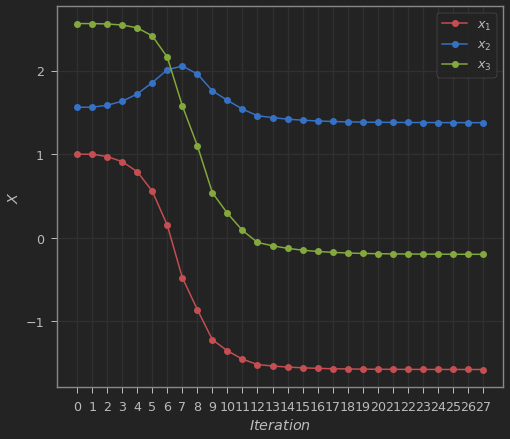

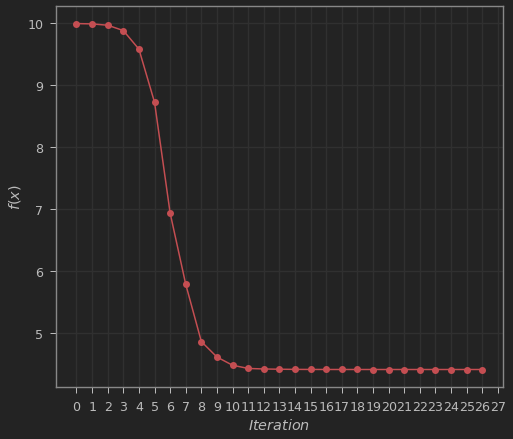

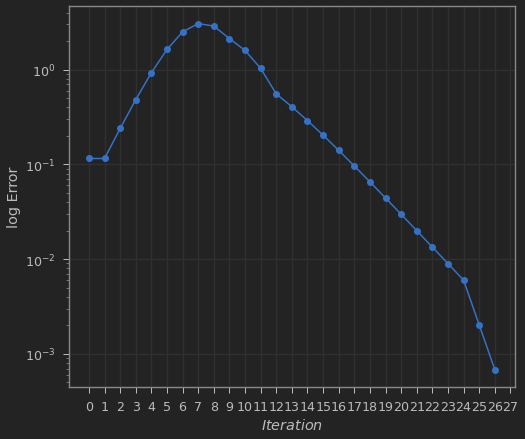

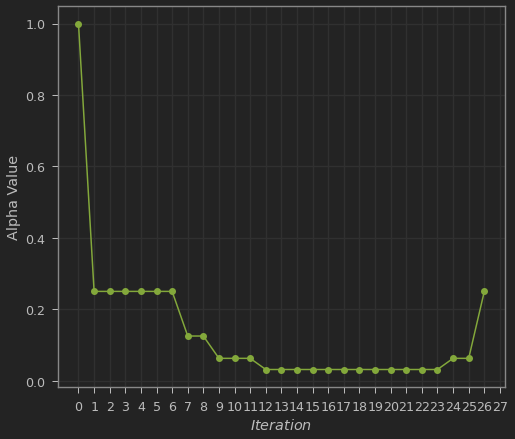


final Results

total number of iteration: 26
Optimal x vlaues are: [-1.5738866  1.3768967 -0.1969896]
f : 4.411768913269043


In [7]:
#Plot Results
print("\n")
plt.plot(x_val[:,0],'ro-')
plt.plot(x_val[:,1],'bo-')
plt.plot(x_val[:,2],'go-')
plt.grid(True)
plt.legend(["$x_1$" ,"$x_2$","$x_3$"])
plt.xlabel("$Iteration$")
plt.ylabel("$X$")
plt.xticks(range(len(x_val[:,0])))
plt.show()
print("\n")
plt.plot(objFun_val,'ro-')
plt.grid(True)
plt.xlabel("$Iteration$")
plt.ylabel("$f(x)$")
plt.xticks(range(len(x_val[:,0])))
plt.show()
print("\n")
plt.plot(error_Val,'bo-')
plt.grid(True)
plt.xlabel("$Iteration$")
plt.yscale("log")
plt.ylabel(r'log Error')
plt.xticks(range(len(x_val[:,0])))
plt.show()
print("\n")
plt.plot(alpha_val,'go-')
plt.grid(True)
plt.xlabel("$Iteration$")
plt.ylabel(r'Alpha Value')
plt.xticks(range(len(x_val[:,0])))
plt.show()   

print("\nfinal Results\n")
print(f'total number of iteration: {k}')
print(f'Optimal x vlaues are: {x.detach().numpy()}')
print(f'f : {f(x)}')